In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
"""
train_type_time_multi.py
"""

import os
import sys
import argparse
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

DEFAULT_NOTEBOOK_CSV_PATH = '/content/drive/MyDrive/Kuning Telur - CV/dataset_index.csv'

def _argv_has_csv(argv):
    for a in argv:
        if a == '--csv' or a.startswith('--csv='):
            return True
    return False

def get_args():
    parser = argparse.ArgumentParser(description="Train yolk TYPE + TIME multi-output classification (MobileNetV2)")
    parser.add_argument('--csv', type=str, required=True, help="Path to dataset_index.csv")
    parser.add_argument('--model_dir', type=str, default="/content/drive/MyDrive/Kuning Telur - CV/Model/ModelCNN_Multi")
    parser.add_argument('--img_size', type=int, default=224)
    parser.add_argument('--batch_size', type=int, default=32)
    parser.add_argument('--epochs', type=int, default=30)
    parser.add_argument('--random_state', type=int, default=42)
    parser.add_argument('--no_prefetch', action='store_true')
    parser.add_argument('--finetune_after', type=int, default=0)

    in_notebook = 'ipykernel' in sys.modules or 'google.colab' in sys.modules
    if in_notebook:
        if _argv_has_csv(sys.argv):
            args, _ = parser.parse_known_args()
        else:
            notebook_argv = [
                '--csv', DEFAULT_NOTEBOOK_CSV_PATH,
                '--epochs', '30'
            ]
            args, _ = parser.parse_known_args(notebook_argv)
    else:
        args = parser.parse_args()
    return args

args = get_args()

CSV_PATH = args.csv
MODEL_DIR = args.model_dir
IMG_SIZE = (args.img_size, args.img_size)
BATCH_SIZE = args.batch_size
EPOCHS = args.epochs
RANDOM_STATE = args.random_state
AUTOTUNE = tf.data.AUTOTUNE if not args.no_prefetch else None
FINETUNE_AFTER = args.finetune_after

os.makedirs(MODEL_DIR, exist_ok=True)

# ----------------- mapping jam -> kondisi (sesuaikan) -----------------
time_to_condition = {
    "12:30": "00",
    "13:00": "30",
    "13:30": "60",
    "14:00": "90",
    "14:30": "120",
    "15:00": "150",
}

# -------------------- Load dataset ----------------------
df = pd.read_csv(CSV_PATH)
required_cols = ['filepath', 'Label_Telur', 'Jam']
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"CSV harus ada kolom '{c}'")

# filter valid type
df = df[df['Label_Telur'].isin(["ayampetelur", "bebek", "puyuh"])].copy()

# mapping waktu
df['TimeLabel'] = df['Jam'].map(time_to_condition)
df = df.dropna(subset=['TimeLabel'])

# mapping ke angka
type_map = {"ayampetelur": 0, "bebek": 1, "puyuh": 2}
time_map = {name: idx for idx, name in enumerate(sorted(df['TimeLabel'].unique()))}

df['label_type'] = df['Label_Telur'].map(type_map).astype('int32')
df['label_time'] = df['TimeLabel'].map(time_map).astype('int32')

print("Samples total:", len(df))
print(df[['Label_Telur', 'Jam', 'TimeLabel']].head())
print("Type map:", type_map)
print("Time map:", time_map)

# -------------------- Stratified split -------------------
train_df, test_df = train_test_split(df, test_size=0.15,
                                     stratify=df['label_type'],
                                     random_state=RANDOM_STATE)
train_df, val_df = train_test_split(train_df, test_size=0.15,
                                    stratify=train_df['label_type'],
                                    random_state=RANDOM_STATE)

# -------------------- Dataset pipeline -------------------
def df_to_tf_dataset(df_local, shuffle=True):
    filepaths = df_local['filepath'].astype(str).values
    labels_type = df_local['label_type'].astype('int32').values
    labels_time = df_local['label_time'].astype('int32').values
    ds = tf.data.Dataset.from_tensor_slices((filepaths, {"out_type": labels_type, "out_time": labels_time}))

    def _load(fp, lbls):
        img = tf.io.read_file(fp)
        img = tf.io.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.cast(img, tf.float32)
        return img, lbls

    ds = ds.map(_load, num_parallel_calls=AUTOTUNE if AUTOTUNE else 1)
    if shuffle:
        ds = ds.shuffle(buffer_size=1000, seed=RANDOM_STATE)
    ds = ds.batch(BATCH_SIZE)
    if AUTOTUNE:
        ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds = df_to_tf_dataset(train_df, shuffle=True)
val_ds = df_to_tf_dataset(val_df, shuffle=False)
test_ds = df_to_tf_dataset(test_df, shuffle=False)

# -------------------- Model builder ----------------------
def get_augmentation():
    return tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.04),
        layers.RandomZoom(0.05),
        layers.RandomTranslation(0.02, 0.02),
        layers.RandomContrast(0.08),
    ], name="augmentation")

def build_model(num_classes_type, num_classes_time):
    base = tf.keras.applications.MobileNetV2(
        input_shape=(*IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    base.trainable = False

    inputs = layers.Input(shape=(*IMG_SIZE, 3), dtype=tf.float32)
    x = get_augmentation()(inputs)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    out_type = layers.Dense(num_classes_type, activation='softmax', name="out_type")(x)
    out_time = layers.Dense(num_classes_time, activation='softmax', name="out_time")(x)

    model = tf.keras.Model(inputs, [out_type, out_time])
    return model, base

model, backbone = build_model(num_classes_type=len(type_map), num_classes_time=len(time_map))

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss={
        "out_type": tf.keras.losses.SparseCategoricalCrossentropy(),
        "out_time": tf.keras.losses.SparseCategoricalCrossentropy(),
    },
    metrics={
        "out_type": [tf.keras.metrics.SparseCategoricalAccuracy(name="acc_type")],
        "out_time": [tf.keras.metrics.SparseCategoricalAccuracy(name="acc_time")],
    }
)

# -------------------- Callbacks --------------------------
ckpt_path = os.path.join(MODEL_DIR, "best_type_time_multi.h5")
cbs = [
    tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_out_type_acc_type", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor="val_out_type_acc_type", patience=6, restore_best_weights=True, mode='max'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7)
]

# -------------------- Training ---------------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=cbs
)

# -------------------- Fine-tune optional -----------------
if FINETUNE_AFTER and FINETUNE_AFTER < EPOCHS:
    backbone.trainable = True
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss={
            "out_type": tf.keras.losses.SparseCategoricalCrossentropy(),
            "out_time": tf.keras.losses.SparseCategoricalCrossentropy(),
        },
        metrics={
            "out_type": [tf.keras.metrics.SparseCategoricalAccuracy(name="acc_type")],
            "out_time": [tf.keras.metrics.SparseCategoricalAccuracy(name="acc_time")],
        }
    )
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=FINETUNE_AFTER,
        callbacks=cbs
    )

# -------------------- Evaluate ---------------------------
eval_res = model.evaluate(test_ds)
print("Eval results:", eval_res)

# -------------------- Save final -------------------------
final_model_path = os.path.join(MODEL_DIR, "final_type_time_multi.h5")
print("Saving final model to:", final_model_path)
model.save(final_model_path)
print("Selesai. Model disimpan ke", final_model_path)

Samples total: 1080
   Label_Telur    Jam TimeLabel
0  ayampetelur  12:30        00
1  ayampetelur  12:30        00
2  ayampetelur  12:30        00
3  ayampetelur  12:30        00
4  ayampetelur  12:30        00
Type map: {'ayampetelur': 0, 'bebek': 1, 'puyuh': 2}
Time map: {'00': 0, '120': 1, '150': 2, '30': 3, '60': 4, '90': 5}
Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.0905 - out_time_acc_time: 0.2110 - out_time_loss: 2.4841 - out_type_acc_type: 0.3672 - out_type_loss: 1.6058

25/25 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 4.0793 - out_time_acc_time: 0.2106 - out_time_loss: 2.4808 - out_type_acc_type: 0.3694 - out_type_loss: 1.5975 - val_loss: 2.9311 - val_out_time_acc_time: 0.2536 - val_out_time_loss: 2.1458 - val_out_type_acc_type: 0.6522 - val_out_type_loss: 0.8590 - learning_rate: 1.0000e-04
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 3.0163 - out_time_acc_time: 0.2694 - out_time_loss: 2.0733 - out_type_acc_type: 0.5743 - out_type_loss: 0.9429

25/25 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - loss: 3.0112 - out_time_acc_time: 0.2694 - out_time_loss: 2.0705 - out_type_acc_type: 0.5761 - out_type_loss: 0.9405 - val_loss: 2.3424 - val_out_time_acc_time: 0.3261 - val_out_time_loss: 1.8575 - val_out_type_acc_type: 0.9203 - val_out_type_loss: 0.5392 - learning_rate: 1.0000e-04
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.4798 - out_time_acc_time: 0.3204 - out_time_loss: 1.8611 - out_type_acc_type: 0.7541 - out_type_loss: 0.6186

25/25 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - loss: 2.4787 - out_time_acc_time: 0.3207 - out_time_loss: 1.8608 - out_type_acc_type: 0.7538 - out_type_loss: 0.6175 - val_loss: 1.9506 - val_out_time_acc_time: 0.3551 - val_out_time_loss: 1.6294 - val_out_type_acc_type: 0.9928 - val_out_type_loss: 0.3669 - learning_rate: 1.0000e-04
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.2275 - out_time_acc_time: 0.3867 - out_time_loss: 1.6870 - out_type_acc_type: 0.7896 - out_type_loss: 0.5402

25/25 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - loss: 2.2225 - out_time_acc_time: 0.3875 - out_time_loss: 1.6834 - out_type_acc_type: 0.7900 - out_type_loss: 0.5385 - val_loss: 1.6646 - val_out_time_acc_time: 0.3986 - val_out_time_loss: 1.4461 - val_out_type_acc_type: 1.0000 - val_out_type_loss: 0.2582 - learning_rate: 1.0000e-04
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - loss: 2.0528 - out_time_acc_time: 0.3864 - out_time_loss: 1.6807 - out_type_acc_type: 0.8669 - out_type_loss: 0.3710 - val_loss: 1.4606 - val_out_time_acc_time: 0.5217 - val_out_time_loss: 1.3003 - val_out_type_acc_type: 1.0000 - val_out_type_loss: 0.2003 - learning_rate: 1.0000e-04
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - loss: 1.7739 - out_time_acc_time: 0.4619 - out_time_loss: 1.4532 - out_type_acc_type: 0.8857 - out_type_loss: 0.3205 - val_loss: 1.3151 - val_out_time_acc_time: 0.5942 - val_out_time_loss: 1.1954 - val_out_type_acc_type: 1.0000 - val_out_type_loss: 0.1596 - learning_rate: 1.0000e-04
Epo

Eval results: [1.7485685348510742, 0.2462744265794754, 1.570616364479065, 0.37037035822868347, 1.0]
Saving final model to: /content/drive/MyDrive/Kuning Telur - CV/Model/ModelCNN_Multi/final_type_time_multi.h5
Selesai. Model disimpan ke /content/drive/MyDrive/Kuning Telur - CV/Model/ModelCNN_Multi/final_type_time_multi.h5


/tmp/ipython-input-4181379882.py:32: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4181379882.py:32: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


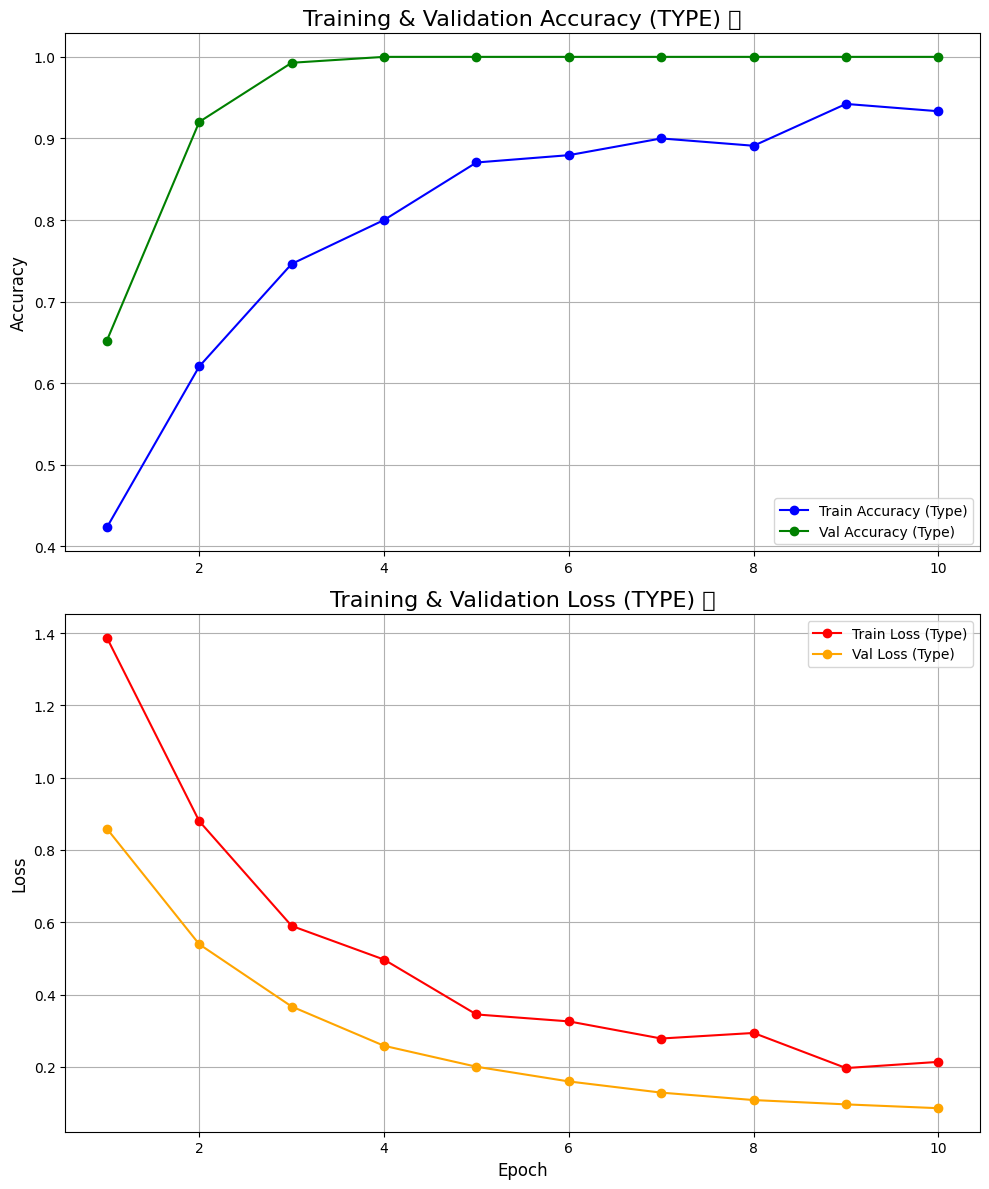

/tmp/ipython-input-4181379882.py:57: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4181379882.py:57: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


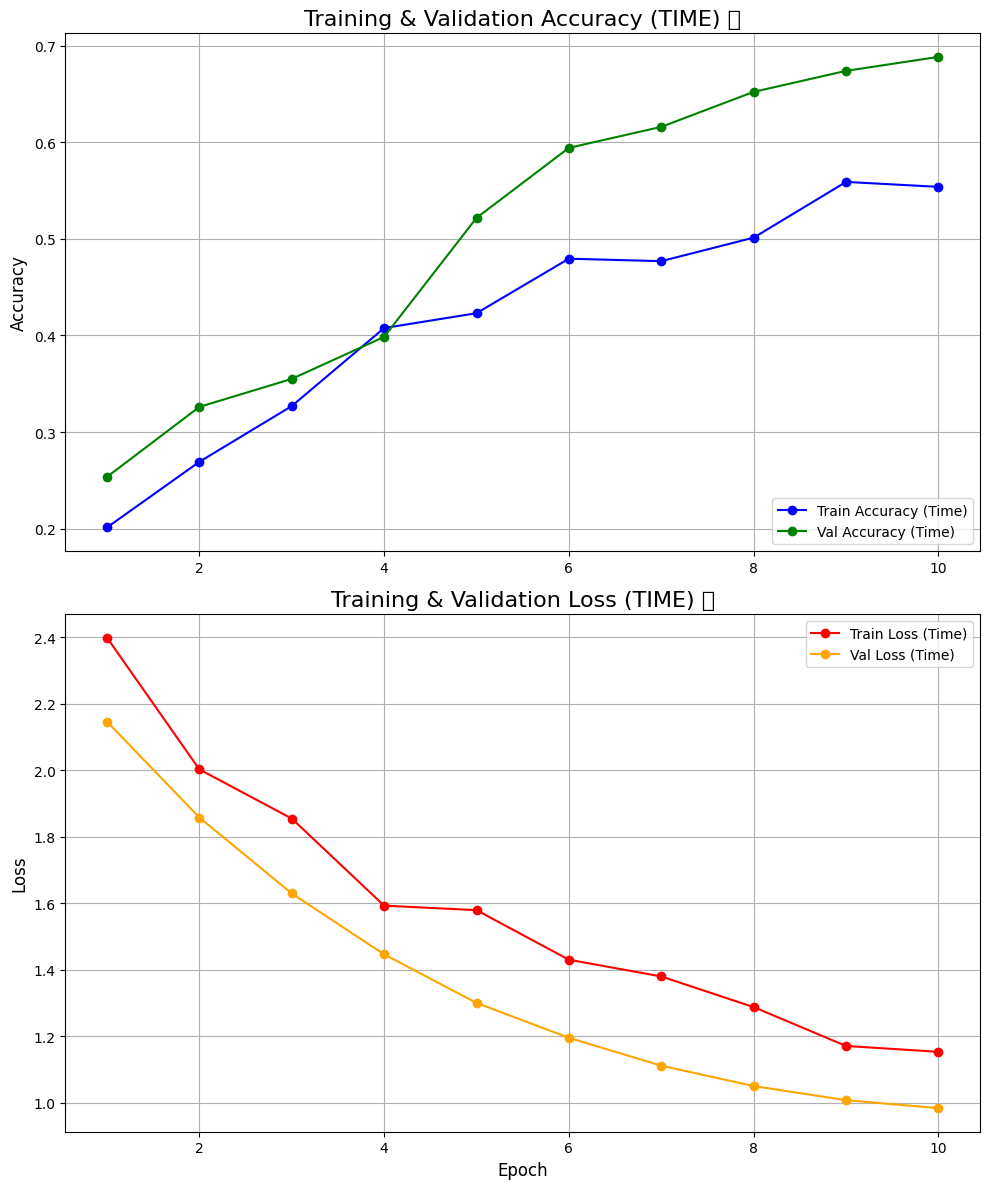

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Ambil history dictionary
hist = history.history
epochs_range = range(1, len(hist['loss'])+1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

acc_type = hist['out_type_acc_type']
val_acc_type = hist['val_out_type_acc_type']
loss = hist['out_type_loss']
val_loss = hist['val_out_type_loss']

ax1.plot(epochs_range, acc_type, 'o-', label='Train Accuracy (Type)', color='b')
ax1.plot(epochs_range, val_acc_type, 'o-', label='Val Accuracy (Type)', color='g')
ax1.set_title('Training & Validation Accuracy (TYPE) 📈', fontsize=16)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(loc='lower right')
ax1.grid(True)

ax2.plot(epochs_range, loss, 'o-', label='Train Loss (Type)', color='r')
ax2.plot(epochs_range, val_loss, 'o-', label='Val Loss (Type)', color='orange')
ax2.set_title('Training & Validation Loss (TYPE) 📉', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True)

plt.tight_layout()
plt.show()

fig, (ax3, ax4) = plt.subplots(2, 1, figsize=(10, 12))

acc_time = hist['out_time_acc_time']
val_acc_time = hist['val_out_time_acc_time']
loss_time = hist['out_time_loss']
val_loss_time = hist['val_out_time_loss']

ax3.plot(epochs_range, acc_time, 'o-', label='Train Accuracy (Time)', color='b')
ax3.plot(epochs_range, val_acc_time, 'o-', label='Val Accuracy (Time)', color='g')
ax3.set_title('Training & Validation Accuracy (TIME) 📈', fontsize=16)
ax3.set_ylabel('Accuracy', fontsize=12)
ax3.legend(loc='lower right')
ax3.grid(True)

ax4.plot(epochs_range, loss_time, 'o-', label='Train Loss (Time)', color='r')
ax4.plot(epochs_range, val_loss_time, 'o-', label='Val Loss (Time)', color='orange')
ax4.set_title('Training & Validation Loss (TIME) 📉', fontsize=16)
ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('Loss', fontsize=12)
ax4.legend(loc='upper right')
ax4.grid(True)

plt.tight_layout()
plt.show()

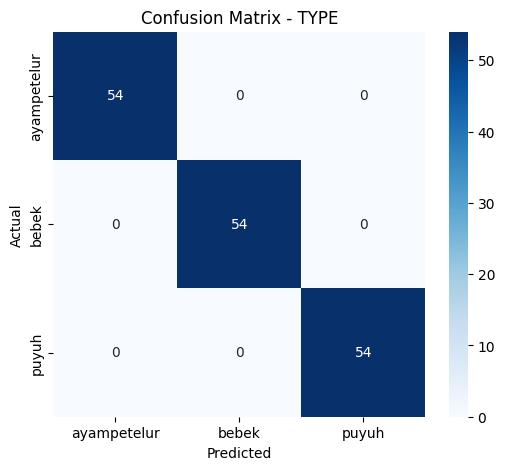


Classification Report (TYPE):
              precision    recall  f1-score   support

 ayampetelur       1.00      1.00      1.00        54
       bebek       1.00      1.00      1.00        54
       puyuh       1.00      1.00      1.00        54

    accuracy                           1.00       162
   macro avg       1.00      1.00      1.00       162
weighted avg       1.00      1.00      1.00       162



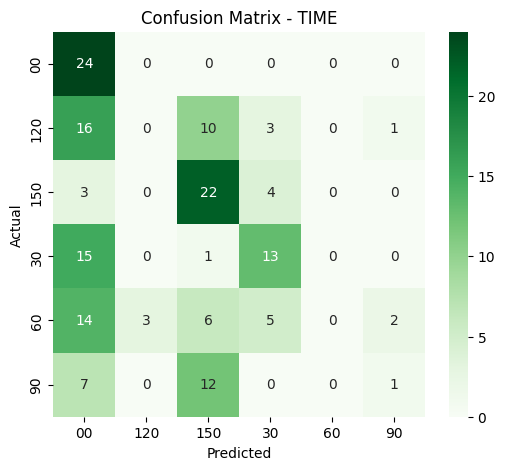


Classification Report (TIME):
              precision    recall  f1-score   support

          00       0.30      1.00      0.47        24
         120       0.00      0.00      0.00        30
         150       0.43      0.76      0.55        29
          30       0.52      0.45      0.48        29
          60       0.00      0.00      0.00        30
          90       0.25      0.05      0.08        20

    accuracy                           0.37       162
   macro avg       0.25      0.38      0.26       162
weighted avg       0.25      0.37      0.26       162



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [8]:
# Ambil prediksi model di test set
y_true_type = []
y_true_time = []
y_pred_type = []
y_pred_time = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    preds_type = np.argmax(preds[0], axis=1)  # out_type
    preds_time = np.argmax(preds[1], axis=1)  # out_time

    y_true_type.extend(labels['out_type'].numpy())
    y_true_time.extend(labels['out_time'].numpy())
    y_pred_type.extend(preds_type)
    y_pred_time.extend(preds_time)

y_true_type = np.array(y_true_type)
y_true_time = np.array(y_true_time)
y_pred_type = np.array(y_pred_type)
y_pred_time = np.array(y_pred_time)

# Confusion Matrix TYPE
cm_type = confusion_matrix(y_true_type, y_pred_type)
plt.figure(figsize=(6,5))
sns.heatmap(cm_type, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(type_map.keys()),
            yticklabels=list(type_map.keys()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - TYPE')
plt.show()

print("\nClassification Report (TYPE):")
print(classification_report(y_true_type, y_pred_type, target_names=list(type_map.keys())))

# Confusion Matrix TIME
# Buat reverse map untuk time_map supaya urut label
sorted_time_labels = [k for k,v in sorted(time_map.items(), key=lambda x: x[1])]

cm_time = confusion_matrix(y_true_time, y_pred_time)
plt.figure(figsize=(6,5))
sns.heatmap(cm_time, annot=True, fmt='d', cmap='Greens',
            xticklabels=sorted_time_labels,
            yticklabels=sorted_time_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - TIME')
plt.show()

print("\nClassification Report (TIME):")
print(classification_report(y_true_time, y_pred_time, target_names=sorted_time_labels))